In [ ]:
import pandas as pd  
import numpy as np 

In [ ]:
from tensorflow.keras import callbacks, models, layers, preprocessing as kprocessing

In [ ]:
from google.colab import files
data = files.upload()

Saving Final_data.csv to Final_data.csv


In [ ]:
data = pd.read_csv('Final_data.csv')
corpus = []
for sent in data['Reviews']:
    corpus.append(sent)



In [ ]:
itrain = corpus[:40000]
itest = corpus[40000:50000]

In [ ]:
df_train = pd.DataFrame(itrain)
df_test = pd.DataFrame(itest)

In [ ]:
special_tokens = ("<START>", "<END>")
df_train = df_train.apply(lambda x: 
                     special_tokens[0]+' '+x+' '+special_tokens[1])
df_test = df_test.apply(lambda x: 
                     special_tokens[0]+' '+x+' '+special_tokens[1])

In [ ]:
test = []
for arr in df_test.values:
    test.append(str(arr))


train = []
for arr in df_train.values:
    train.append(str(arr))



In [ ]:
train_tokenizer = kprocessing.text.Tokenizer(lower=False, split=' ', oov_token=None, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
train_tokenizer.fit_on_texts(train)
X_train_vocab = {"<PAD>":0}
X_train_vocab.update(train_tokenizer.word_index)


lst_text2seq= train_tokenizer.texts_to_sequences(train)

X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

In [ ]:
test_tokenizer = kprocessing.text.Tokenizer( lower=False, split=' ', oov_token=None, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
test_tokenizer.fit_on_texts(train)
X_test_vocab = {"<PAD>":0}
X_test_vocab.update(test_tokenizer.word_index)



lst_text2seq = test_tokenizer.texts_to_sequences(test)
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

In [ ]:
import gensim.downloader as api
nlp = api.load("glove-twitter-25")

[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
X_embeddings = np.zeros((len(X_train_vocab)+1, 300)) 
for word,idx in X_train_vocab.items():
    ## update the row with vector
    try:
        X_embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [ ]:
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense, Input, Embedding, Attention,Concatenate
from tensorflow.keras import Model

In [ ]:
latent_dim = 300
embedding_dim = 200
max_length = 15

# Encoder
encoder_inputs = Input(shape=(max_length, ))

# Embedding layer
enc_emb = Embedding(len(X_train_vocab), embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(len(X_train_vocab), embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(len(X_train_vocab), activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 15, 200)      21174400    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 15, 300),    601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
lis = [[1,2,3],[5,6,7],[7,5,3]]

In [ ]:
history = model.fit(
    [X_train, X_train[:, :-1]],
    X_train.reshape(X_train.shape[0], X_train.shape[1], 1)[:, 1:],
    epochs=20,
    
    batch_size=128,
    validation_data=([X_test, X_test[:, :-1]],
                     X_test.reshape(X_test.shape[0], X_test.shape[1], 1)[:
                     , 1:]),
    )

Epoch 1/20
313/313 [==============================] - 168s 538ms/step - loss: 4.1625 - val_loss: 4.2238
Epoch 2/20
313/313 [==============================] - 167s 534ms/step - loss: 4.0753 - val_loss: 4.1511
Epoch 3/20
313/313 [==============================] - 167s 533ms/step - loss: 3.9902 - val_loss: 4.0924
Epoch 4/20
313/313 [==============================] - 167s 532ms/step - loss: 3.9132 - val_loss: 4.0399
Epoch 5/20
313/313 [==============================] - 167s 532ms/step - loss: 3.8418 - val_loss: 3.9659
Epoch 6/20
313/313 [==============================] - 167s 534ms/step - loss: 3.7729 - val_loss: 3.9067
Epoch 7/20
313/313 [==============================] - 167s 534ms/step - loss: 3.7022 - val_loss: 3.8433
Epoch 8/20
313/313 [==============================] - 167s 532ms/step - loss: 3.6378 - val_loss: 3.7827
Epoch 9/20
313/313 [==============================] - 167s 533ms/step - loss: 3.5800 - val_loss: 3.7371
Epoch 10/20
313/313 [==============================] - 167s 534m

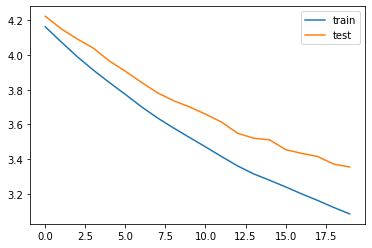

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
reverse_target_word_index = train_tokenizer.index_word
reverse_source_word_index = train_tokenizer.index_word
target_word_index = train_tokenizer.word_index


In [ ]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_length, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['<START>']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != '<END>':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == '<END>' or len(decoded_sentence.split()) \
            >= max_length - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [ ]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['<START>'] and i \
            != target_word_index['<END>']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

In [ ]:
for i in range(0, 19):
    
    print ('Original text:', seq2summary(X_train[i]))
    print ('Predicted text:', decode_sequence(X_train[i].reshape(1,
           max_length)))
    print()

Original text: one reviewer mentioned watching 1 oz episode hooked right exactly happened me the first 
Predicted text:  one reviewer mentioned watching 1 woody allen always trying sit someone right story first

Original text: '<START> wonderful little production filming technique unassuming old time bbc fashion give comforting sometimes discomforting 
Predicted text:  wonderful little production filming old technique old time bbc company can't find basic character

Original text: '<START> thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light 
Predicted text:  thought wonderful way spend time travel summer air channel air theater father see light

Original text: basically there's family little boy jake think there's zombie closet parent fighting time this 
Predicted text:  basically there's girl little boy sorry think except zombie baby girl father even get

Original text: '<START> petter mattei 's love time money visually stunning film watc